In [1]:
# -*- coding: utf-8 -*-
import os
os.environ['KERAS_BACKEND'] = 'tensorflow'

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import keras
import tensorflow as tf
import bayesflow as bf

current_backend = tf.keras.backend.backend()
print(f"tf.keras is using the '{current_backend}' backend.")

2025-07-11 19:32:25.699943: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M1 Pro
2025-07-11 19:32:25.699977: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 16.00 GB
2025-07-11 19:32:25.699983: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 5.33 GB
I0000 00:00:1752255145.699999 1562317 pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
I0000 00:00:1752255145.700021 1562317 pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)
INFO:bayesflow:Using backend 'tensorflow'


tf.keras is using the 'tensorflow' backend.


In [2]:
# Trial code to generate a sequence using a Hidden Markov Model (HMM)
# This code uses the hmmlearn library to create a categorical HMM with fixed parameters.
# It generates a sequence of observations and computes the posterior probabilities of the states.

import numpy as np
from hmmlearn import hmm

# 1) Initialize model
model = hmm.CategoricalHMM(n_components=2, algorithm='viterbi',
                           n_iter=0, init_params='')  # No EM

# 2) Fix parameters:
model.startprob_ = np.array([1.0, 0.0])        # always begin in “other”
model.transmat_  = np.array([[0.95, 0.05],     # other → other/helix
                             [0.10, 0.90]])    # helix → other/helix
model.emissionprob_ = np.array([
        [0.12, 0.06, 0.03, 0.05, 0.01, 0.09, 0.05, 0.04, 0.02, 0.07, 0.12, 0.06, 0.03, 0.04, 0.02, 0.05, 0.04, 0.01, 0.03, 0.06],
        [0.06, 0.05, 0.05, 0.06, 0.02, 0.05, 0.03, 0.09, 0.03, 0.05, 0.08, 0.06, 0.02, 0.04, 0.06, 0.07, 0.06, 0.01, 0.04, 0.07]
    ])          # 2×20 table from Task 1

# 3) Generate a sequence + state probs:
X, Z = model.sample(n_samples=200)
post = model.predict_proba(X)

print("X shape:", X.shape, "Z shape:", Z.shape)
print("Post shape:", post.shape)
print("Generated sequence (X):", X[:10])
print("State probabilities (post):", post[:10])

X shape: (200, 1) Z shape: (200,)
Post shape: (200, 2)
Generated sequence (X): [[17]
 [ 2]
 [ 3]
 [15]
 [ 7]
 [ 9]
 [ 1]
 [14]
 [19]
 [ 0]]
State probabilities (post): [[1.         0.        ]
 [0.81844718 0.18155282]
 [0.71413547 0.28586453]
 [0.62987609 0.37012391]
 [0.57716999 0.42283001]
 [0.58717176 0.41282824]
 [0.56941789 0.43058211]
 [0.53420259 0.46579741]
 [0.58393465 0.41606535]
 [0.64504162 0.35495838]]


In [3]:
# Step 4: Implementing the HMM Simulator with hmmlearn.CategoricalHMM

import numpy as np
from hmmlearn import hmm

# 4.1 Define the fixed emission & transition matrices from Task 1
n_states = 2           # 0 = "other", 1 = "alpha‐helix"
n_amino_acids = 20     # 20 standard residues

# Transition: rows sum to 1; row[0] = other→(other, helix), row[1] = helix→(other, helix)
transmat = np.array([
    [0.95, 0.05],   # other → other / helix
    [0.10, 0.90],   # helix → other / helix
])

# Start in "other" with probability 1.0
startprob = np.array([1.0, 0.0])

# Emission probabilities: shape (n_states, n_amino_acids)
# Row 0: "other"; Row 1: "alpha‐helix"
emissionprob = np.array([
    [0.06, 0.05, 0.05, 0.06, 0.02, 0.05, 0.03, 0.09, 0.03, 0.05,
     0.08, 0.06, 0.02, 0.04, 0.06, 0.07, 0.06, 0.01, 0.04, 0.07],
    [0.12, 0.06, 0.03, 0.05, 0.01, 0.09, 0.05, 0.04, 0.02, 0.07,
     0.12, 0.06, 0.03, 0.04, 0.02, 0.05, 0.04, 0.01, 0.03, 0.06],
])

# 4.2 Build the CategoricalHMM with parameters frozen (no EM training)
model = hmm.CategoricalHMM(
    n_components=n_states,
    algorithm='viterbi', # use forward–backward ("viterbi") for predict_proba
    n_iter=0,            # skip EM
    init_params=''       # do not re-initialize any parameters
)

model.startprob_    = startprob
model.transmat_     = transmat
model.emissionprob_ = emissionprob

# 4.3 Simulator function
def simulate_batch(sequence_length, batch_size, random_state=None):
    """
    Simulate `batch_size` independent HMM sequences of length `sequence_length`.
    Returns:
      X_batch: np.ndarray, shape (batch_size, sequence_length), dtype=int
               (integer‐encoded amino‐acid observations 0..19)
      P_batch: np.ndarray, shape (batch_size, sequence_length, n_states),
               posterior state-membership probabilities
    """
    X_batch = np.zeros((batch_size, sequence_length), dtype=int)
    P_batch = np.zeros((batch_size, sequence_length, n_states))

    # Option A: call .sample for each sequence independently
    for i in range(batch_size):
        # sample returns (observations, latent_states)
        X_i, Z_i = model.sample(n_samples=sequence_length, random_state=random_state)
        # X_i is (sequence_length, 1) of ints in [0,19]; squeeze to 1D
        X_i = X_i.squeeze().astype(int)

        # compute posterior probabilities via forward–backward
        post_i = model.predict_proba(X_i.reshape(-1, 1))

        X_batch[i] = X_i
        P_batch[i] = post_i

    return X_batch, P_batch

# Example usage
if __name__ == "__main__":
    seq_len   = 200
    batch_sz  = 4
    X, P = simulate_batch(seq_len, batch_sz, random_state=42)

    print("X.shape:", X.shape)       # (4, 200)
    print("P.shape:", P.shape)       # (4, 200, 2)
    print("First sequence obs:", X[0, :10])
    print("First sequence posteriors:", P[0, :10, :])

X.shape: (4, 200)
P.shape: (4, 200, 2)
First sequence obs: [19 11  2 16 14 19  3  3 10  6]
First sequence posteriors: [[1.         0.        ]
 [0.98569035 0.01430965]
 [0.98170387 0.01829613]
 [0.97700983 0.02299017]
 [0.97265727 0.02734273]
 [0.94451754 0.05548246]
 [0.91752723 0.08247277]
 [0.88835249 0.11164751]
 [0.85465933 0.14534067]
 [0.849613   0.150387  ]]


In [4]:
import numpy as np
from bayesflow.simulators import LambdaSimulator
from bayesflow.approximators import ContinuousApproximator
from bayesflow.adapters import Adapter
from bayesflow.datasets import OnlineDataset

# 4) Define a sample function for BayesFlow with fixed sequence length
SEQUENCE_LENGTH = 200  # Define this as a constant

def bayesflow_sample_fn(batch_shape, random_state=None):
    """
    batch_shape : tuple[int,...], e.g. (batch_size,)
    random_state : optional RNG seed
    
    Returns a dict mapping variable names → numpy arrays:
      - "observations": int arrays of shape (batch_size, sequence_length)
      - "states":       int arrays of shape (batch_size, sequence_length)
    """
    # Determine batch size
    batch_size = int(np.prod(batch_shape))
    
    # Simulate with fixed sequence length
    X_batch, P_batch = simulate_batch(
        sequence_length=SEQUENCE_LENGTH,
        batch_size=batch_size,
        random_state=random_state
    )
    
    # CRITICAL FIX: Ensure observations are integers in the correct range
    # Convert to int32 and ensure values are in [0, 19] range
    X_batch = X_batch.astype(np.int32)
    P_batch = P_batch.astype(np.float32)
    
    # Debug: Check the data types and ranges
    # print(f"X_batch dtype: {X_batch.dtype}")
    # print(f"X_batch shape: {X_batch.shape}")
    # print(f"X_batch min: {X_batch.min()}, max: {X_batch.max()}")
    # print(f"P_batch dtype: {P_batch.dtype}")
    # print(f"P_batch shape: {P_batch.shape}")
    
    # Ensure observations are in valid range [0, 19]
    if X_batch.min() < 0 or X_batch.max() >= 20:
        raise ValueError(f"Observations must be in range [0, 19], got [{X_batch.min()}, {X_batch.max()}]")
    
    # Convert to numpy arrays
    X_batch = np.asarray(X_batch, dtype=np.int32)  # Ensure integer type
    P_batch = np.asarray(P_batch, dtype=np.float32)  # Ensure float type
    
    return {
        "observations": X_batch,   # integer codes
        "posteriors":   P_batch    # continuous [0,1] probabilities
    }

# 5) Wrap in LambdaSimulator
simulator = LambdaSimulator(
    sample_fn=bayesflow_sample_fn,
    is_batched=True        # our sample_fn handles the full batch in one call
)

In [5]:
# 1) Build the base adapter: map your raw simulator output
#    - "posteriors" → "inference_variables" 
#    - "observations" → "summary_variables"
adapter = ContinuousApproximator.build_adapter(
    inference_variables=["posteriors"],
    summary_variables=["observations"]
)

# 2) CRITICAL FIX: Convert summary_variables back to integers and squeeze extra dimension
# The base adapter converts int32 to float32 and adds dimension, we need to reverse this
from bayesflow.adapters.transforms import Transform
from bayesflow.adapters.transforms.map_transform import MapTransform
import numpy as np

class IntegerSqueezeTransform(Transform):
    """Custom transform to convert float32 back to int32 and squeeze extra dimension"""
    
    def forward(self, data, **kwargs):
        # Convert to int32 and squeeze the last dimension if it's size 1
        if data.ndim == 3 and data.shape[-1] == 1:
            data = data.squeeze(-1)  # Remove last dimension
        return data.astype(np.int32)
    
    def inverse(self, data, **kwargs):
        # Add back the dimension and convert to float32
        return data.astype(np.float32)[..., np.newaxis]
    
class ReshapeTransform(Transform):
    """Custom transform to reshape posteriors from (batch, seq, states) to (batch, seq*states)"""
    
    def forward(self, data, **kwargs):
        batch_size = data.shape[0]
        return data.reshape(batch_size, -1)  # Flatten last two dimensions

    def inverse(self, data, **kwargs):
        # Handle both (batch, seq*states) and (batch, num_samples, seq*states)
        if data.ndim == 2:
            batch_size = data.shape[0]
            return data.reshape(batch_size, SEQUENCE_LENGTH, n_states)
        elif data.ndim == 3:
            batch_size, num_samples = data.shape[:2]
            return data.reshape(batch_size, num_samples, SEQUENCE_LENGTH, n_states)
        else:
            raise ValueError(f"Unexpected data shape in ReshapeTransform.inverse: {data.shape}")

# Create a MapTransform to apply only to summary_variables
integer_squeeze_map = MapTransform(
    transform_map={"summary_variables": IntegerSqueezeTransform()}
)

reshape_map = MapTransform(
    transform_map={"inference_variables": ReshapeTransform()}
)

# Add the transform to the adapter
adapter = adapter.append(integer_squeeze_map)
adapter = adapter.append(reshape_map)

# 3) One-hot encode the summary inputs (now named "summary_variables")
adapter = adapter.one_hot(
    keys="summary_variables",
    num_classes=20
)

# 4) Convert all floats to float32 for TensorFlow
adapter = adapter.convert_dtype(
    from_dtype="float64",
    to_dtype="float32"
)

# 1) Re-initialize the dataset
dataset = OnlineDataset(
    simulator=simulator,          # your LambdaSimulator
    batch_size=64,                # sequences per batch
    num_batches=1000,             # batches per epoch
    adapter=adapter,              # adapter with integer squeeze fix
    stage="training",             # adapter stage
)

# 2) Test the final working version
print("=== Final working version ===")
batch = dataset[0]

# 3) Inspect the final batch
print("Keys in batch:", batch.keys())  
print("summary_variables shape:   ", batch["summary_variables"].shape)    # → (64, 200, 20)
print("inference_variables shape:", batch["inference_variables"].shape)  # → (64, 200, 2)
print("summary_variables dtype:   ", batch["summary_variables"].dtype)    # → float32
print("inference_variables dtype: ", batch["inference_variables"].dtype)  # → float32

# 4) Verify the one-hot encoding worked correctly
print("\nVerifying one-hot encoding:")
print("summary_variables sum along last axis (should be all 1s):", 
      batch["summary_variables"].sum(axis=-1)[0, :10])  # First 10 timesteps of first sequence
print("inference_variables range:", 
      batch["inference_variables"].min(), "to", batch["inference_variables"].max())

print("\n✅ Success! Your BayesFlow adapter is working correctly.")

=== Final working version ===
Keys in batch: dict_keys(['inference_variables', 'summary_variables'])
summary_variables shape:    (64, 200, 20)
inference_variables shape: (64, 400)
summary_variables dtype:    float32
inference_variables dtype:  float32

Verifying one-hot encoding:
summary_variables sum along last axis (should be all 1s): [1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
inference_variables range: 0.0 to 1.0

✅ Success! Your BayesFlow adapter is working correctly.


In [6]:
# Step 7: Define the Summary Network (TimeSeriesNetwork)

import tensorflow as tf
from bayesflow.networks import TimeSeriesNetwork

# 7.1 Instantiate a TimeSeriesNetwork to embed (batch, 200, 20) → (batch, 64)
summary_network = TimeSeriesNetwork(
    summary_dim=200,              # final embedding size per sequence :contentReference[oaicite:0]{index=0}
    filters=[64, 128],            # two Conv1D layers with 32 and 64 filters :contentReference[oaicite:1]{index=1}
    kernel_sizes=[3, 3],          # 3-length kernels for each conv layer :contentReference[oaicite:2]{index=2}
    strides=[1, 1],               # unit strides for convolution :contentReference[oaicite:3]{index=3}
    activation="mish",            # Mish activation in conv layers :contentReference[oaicite:4]{index=4}
    kernel_initializer="glorot_uniform",  # Xavier uniform initialization :contentReference[oaicite:5]{index=5}
    groups=None,                  # no group normalization :contentReference[oaicite:6]{index=6}
    recurrent_type="lstm",        # use GRU in the recurrent module :contentReference[oaicite:7]{index=7}
    recurrent_dim=256,            # 128 hidden units in GRU :contentReference[oaicite:8]{index=8}
    bidirectional=True,           # bidirectional recurrence :contentReference[oaicite:9]{index=9}
    dropout=0.05,                 # 5% dropout in the recurrent module :contentReference[oaicite:10]{index=10}
    skip_steps=4                  # skip-connections every 4 timesteps :contentReference[oaicite:11]{index=11}
)

# 7.2 Sanity-check: pass a dummy batch through the summary network
dummy_input = tf.random.uniform((8, 200, 20), dtype=tf.float32)
dummy_summary = summary_network(dummy_input)
print("dummy_summary.shape =", dummy_summary.shape)  # expects (8, 64)

dummy_summary.shape = (8, 200)


In [7]:
# Step 8.1: Define a FlowMatching-based inference network

import tensorflow as tf
from bayesflow.networks import FlowMatching, MLP

class KLDivergenceLoss(keras.losses.Loss):
    """Improved KL divergence loss with better numerical stability"""
    
    def __init__(self, epsilon=1e-8, name="improved_kl_divergence"):
        super().__init__(name=name)
        self.epsilon = epsilon
    
    def call(self, y_true, y_pred):
        # Reshape to (batch_size, sequence_length, n_states)
        batch_size = tf.shape(y_true)[0]
        y_true_reshaped = tf.reshape(y_true, (batch_size, SEQUENCE_LENGTH, n_states))
        y_pred_reshaped = tf.reshape(y_pred, (batch_size, SEQUENCE_LENGTH, n_states))
        
        # Apply softmax to ensure valid probabilities
        y_true_prob = tf.nn.softmax(y_true_reshaped, axis=-1)
        y_pred_prob = tf.nn.softmax(y_pred_reshaped, axis=-1)
        
        # Clip for numerical stability
        y_true_prob = tf.clip_by_value(y_true_prob, self.epsilon, 1.0 - self.epsilon)
        y_pred_prob = tf.clip_by_value(y_pred_prob, self.epsilon, 1.0 - self.epsilon)
        
        # Calculate KL divergence
        kl_div = y_true_prob * tf.math.log(y_true_prob / y_pred_prob)
        return tf.reduce_mean(tf.reduce_sum(kl_div, axis=[1, 2]))

# FIXED: Calculate the expected input dimension correctly
# Input to FlowMatching subnet = inference_vars + summary_vars + time
# inference_vars: SEQUENCE_LENGTH * n_states = 200 * 2 = 400
# summary_vars: summary_dim = 200 (from TimeSeriesNetwork)
# time: 1
# Total: 400 + 200 + 1 = 601

expected_input_dim = SEQUENCE_LENGTH * n_states + 200 + 1  # 601
output_dim = SEQUENCE_LENGTH * n_states  # 400

# 1. Instantiate the FlowMatching inference network with correct dimensions
inference_network = FlowMatching(
    subnet=MLP(
        widths=[512, 512, 256, output_dim],  # Increased capacity and correct output dim
        activation="mish",
        dropout=0.05
    ),
    base_distribution="normal",
    use_optimal_transport=True,
    loss_fn=KLDivergenceLoss,

)

# 2. Create dummy data for testing with correct shapes
batch_size = 8
summary_dim = 200  # This should match TimeSeriesNetwork output

dummy_summary = tf.random.uniform(
    (batch_size, summary_dim), dtype=tf.float32
)
dummy_target = tf.random.uniform(
    (batch_size, SEQUENCE_LENGTH, n_states), dtype=tf.float32
)

# Flatten the target to shape (batch_size, SEQUENCE_LENGTH*n_states)
dummy_xz = tf.reshape(dummy_target, (batch_size, -1))  # → (8, 400)

print(f"Expected input dimension: {expected_input_dim}")
print(f"dummy_xz shape: {dummy_xz.shape}")
print(f"dummy_summary shape: {dummy_summary.shape}")
print(f"Total input would be: {dummy_xz.shape[1]} + {dummy_summary.shape[1]} + 1 = {dummy_xz.shape[1] + dummy_summary.shape[1] + 1}")

# 3. Build the network with correct input shapes
inference_network.build(
    xz_shape=dummy_xz.shape,
    conditions_shape=dummy_summary.shape
)

# 4. Test the network
t = tf.random.uniform((batch_size,), dtype=tf.float32)
velocity = inference_network.velocity(
    xz=dummy_xz,
    time=t,
    conditions=dummy_summary,
    training=False
)
print("Velocity shape:", velocity.shape)  # Expected: (8, 400)

# 5. Compute training metrics
metrics = inference_network.compute_metrics(
    x=dummy_xz,
    conditions=dummy_summary
)
print("Available metrics:", list(metrics.keys()))
print("Loss value:", metrics["loss"])

print("\n✅ FlowMatching network configured correctly!")

Expected input dimension: 601
dummy_xz shape: (8, 400)
dummy_summary shape: (8, 200)
Total input would be: 400 + 200 + 1 = 601
Velocity shape: (8, 400)
Available metrics: ['loss']
Loss value: tf.Tensor(203.86215, shape=(), dtype=float32)

✅ FlowMatching network configured correctly!


In [8]:
import tensorflow as tf
from bayesflow.networks import CouplingFlow

inference_network = CouplingFlow(
    subnet=MLP(
        widths=[512, 512, 256, output_dim],  # Increased capacity and correct output dim
        activation="mish",
        dropout=0.05
    ),
    base_distribution="normal",
    use_actnorm=True
)

# 2. Create dummy data for testing with correct shapes
batch_size = 8
summary_dim = 200  # This should match TimeSeriesNetwork output

dummy_summary = tf.random.uniform(
    (batch_size, summary_dim), dtype=tf.float32
)
dummy_target = tf.random.uniform(
    (batch_size, SEQUENCE_LENGTH, n_states), dtype=tf.float32
)

# Flatten the target to shape (batch_size, SEQUENCE_LENGTH*n_states)
dummy_xz = tf.reshape(dummy_target, (batch_size, -1))  # → (8, 400)

print(f"Expected input dimension: {expected_input_dim}")
print(f"dummy_xz shape: {dummy_xz.shape}")
print(f"dummy_summary shape: {dummy_summary.shape}")
print(f"Total input would be: {dummy_xz.shape[1]} + {dummy_summary.shape[1]} + 1 = {dummy_xz.shape[1] + dummy_summary.shape[1] + 1}")

# 3. Build the network with correct input shapes
inference_network.build(
    xz_shape=dummy_xz.shape,
    conditions_shape=dummy_summary.shape
)

# 5. Compute training metrics
metrics = inference_network.compute_metrics(
    x=dummy_xz,
    conditions=dummy_summary
)
print("Available metrics:", list(metrics.keys()))
print("Loss value:", metrics["loss"])

print("\n✅ CouplingFlow network configured correctly!")

Expected input dimension: 601
dummy_xz shape: (8, 400)
dummy_summary shape: (8, 200)
Total input would be: 400 + 200 + 1 = 601
Available metrics: ['loss']
Loss value: tf.Tensor(434.90704, shape=(), dtype=float32)

✅ CouplingFlow network configured correctly!


In [9]:
workflow = bf.workflows.BasicWorkflow(
    simulator=simulator,                                # your LambdaSimulator
    adapter=adapter,                                    # adapter with integer squeeze fix
    inference_network=inference_network,                # FlowMatching or MLP from Step 8
    summary_network=summary_network,                    # TimeSeriesNetwork from Step 7
)

In [11]:
history = workflow.fit_online(
    epochs=1,
    batch_size=64,
    num_batches_per_epoch=3000,
    validation_data=300
)

INFO:bayesflow:Fitting on dataset instance of OnlineDataset.
INFO:bayesflow:Building on a test batch.
2025-07-11 19:33:09.635524: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


3000/3000 ━━━━━━━━━━━━━━━━━━━━ 1151s 379ms/step - loss: -537.7491 - val_loss: -790.2870


/opt/anaconda3/envs/ukk/lib/python3.12/site-packages/bayesflow/diagnostics/plots/loss.py:158: UserWarning: Attempting to set identical low and high xlims makes transformation singular; automatically expanding.
  ax.set_xlim(train_step_index[0], train_step_index[-1])


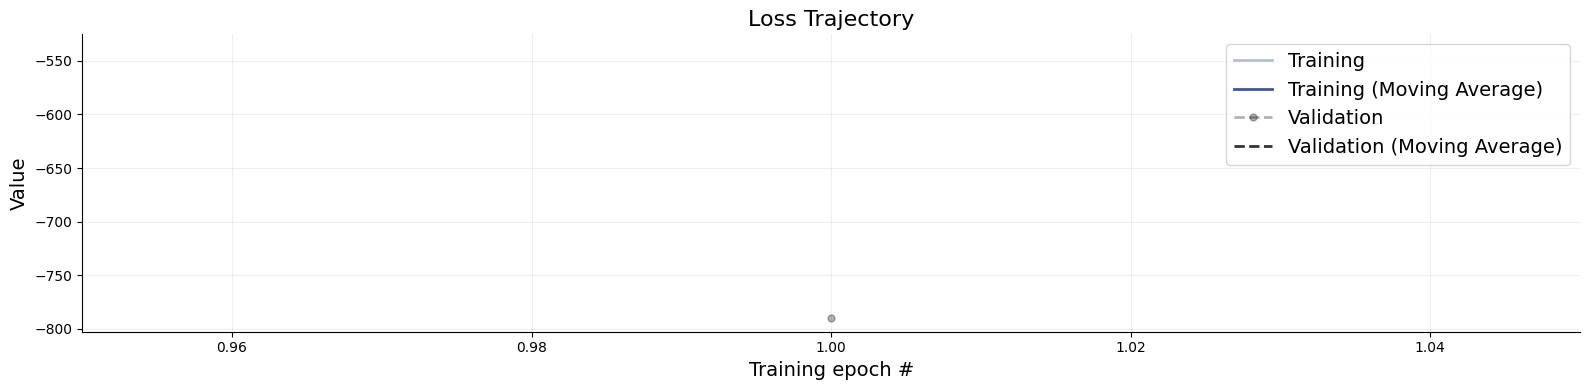

In [12]:
f = bf.diagnostics.plots.loss(history)

In [13]:
test_raw = workflow.simulate(
    batch_shape=300
)

# This is dict_items
test_raw.items()

# I want to see the keys and values of the test_raw dictionary
for key, value in test_raw.items():
    print(f"Key: {key}, Value shape: {value.shape}, Value dtype: {value.dtype}")

Key: observations, Value shape: (300, 200), Value dtype: int32
Key: posteriors, Value shape: (300, 200, 2), Value dtype: float32


In [14]:
# Simulate 300 scenarios
test_raw = workflow.simulate(batch_shape=(300, 2))

# Use the "observations" as the conditioning variable
conditions = {"observations": test_raw["observations"]}

# Set the number of posterior samples you want to draw for each scenario
num_samples = 10

# Draw samples from the posterior
samples = workflow.sample(conditions=conditions, num_samples=num_samples)

# Inspect the shape of the samples
for key, value in samples.items():
    print(f"Key: {key}, Value shape: {value.shape}, Value dtype: {value.dtype}")

Key: posteriors, Value shape: (600, 10, 200, 2), Value dtype: float64


Estimates shape: (600, 10, 400), Targets shape: (600, 400)
Batch size: 600, Num samples: 10, Seq length: 200, N states: 2


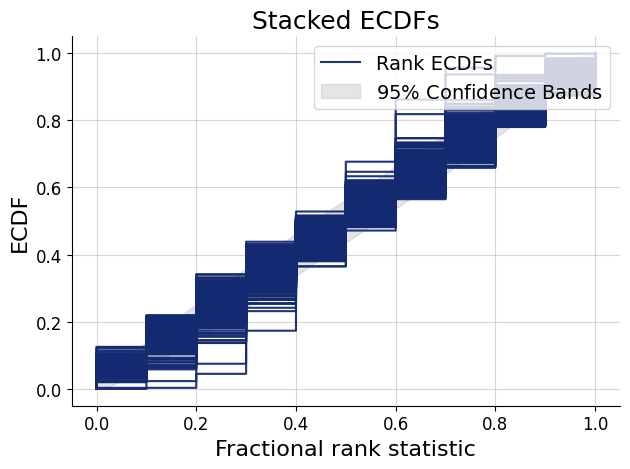

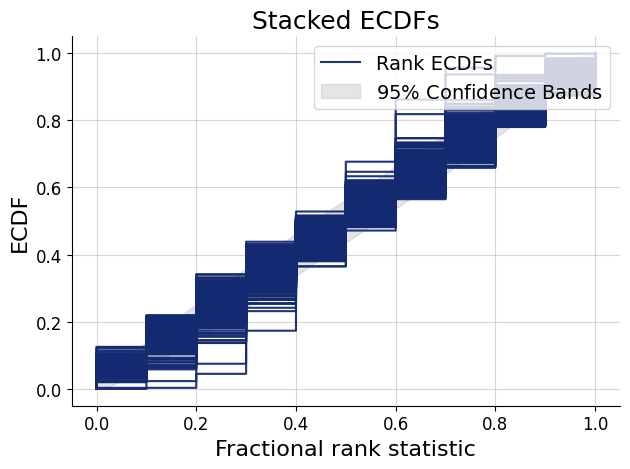

In [17]:
# Reshape samples["posteriors"] and test_raw["posteriors"] for calibration_ecdf
batch, num_samples, seq, n_states = samples["posteriors"].shape
estimates_flat = samples["posteriors"].reshape(batch, num_samples, seq * n_states)
targets_flat = test_raw["posteriors"].reshape(batch, seq * n_states)

print(f"Estimates shape: {estimates_flat.shape}, Targets shape: {targets_flat.shape}")
print(f"Batch size: {batch}, Num samples: {num_samples}, Seq length: {seq}, N states: {n_states}")

bf.diagnostics.calibration_ecdf(
    estimates=estimates_flat,
    targets=targets_flat,
    stacked=True
)

In [ ]:
test_raw   = simulator.sample((256,))

# Create a separate adapter for sampling that doesn't apply one-hot encoding
sampling_adapter = ContinuousApproximator.build_adapter(
    inference_variables=["posteriors"],
    summary_variables=["observations"]
)

# Add only the necessary transforms for sampling
sampling_adapter = sampling_adapter.append(integer_squeeze_map)
sampling_adapter = sampling_adapter.append(reshape_map)
sampling_adapter = sampling_adapter.convert_dtype(
    from_dtype="float64",
    to_dtype="float32"
)

test_adapt = sampling_adapter(test_raw, training=False)

theta_true = test_adapt["inference_variables"]      # (256, 400)
x_raw      = test_adapt["summary_variables"]        # (256, 200)  integers 0..19

print("theta_true:", theta_true.shape)
print("x_raw:",      x_raw.shape)


workflow.sample(
    num_samples=100,
    conditions={"observations": x_summary}
)

In [ ]:
import bayesflow as bf
import numpy as np

# --------------------------------------------------------------------------
# 1. fresh test batch  ➜  *sampling* adapter  (NO one-hot here)
# --------------------------------------------------------------------------


# --------------------------------------------------------------------------
# 2. 100 posterior draws via workflow.sample
#    (one draw per call keeps reshape-inverse happy)
# --------------------------------------------------------------------------
num_draws   = 100
draw_list   = []

for _ in range(num_draws):
    draw = (
        workflow
        .sample(                          # adapter will one-hot once
            num_samples=1,
            conditions={"observations": x_raw},
            to_numpy=True
        )["posteriors"]                   # (256, 200, 2)
        .reshape(x_raw.shape[0], -1)      # ➜ (256, 400)
    )
    draw_list.append(draw)

posterior_samples = np.stack(draw_list, axis=1)  # (256, 100, 400)
print("posterior_samples:", posterior_samples.shape)

# --------------------------------------------------------------------------
# 3. Calibration ECDF
# --------------------------------------------------------------------------
bf.diagnostics.calibration_ecdf(
    estimates=posterior_samples,
    targets=theta_true,
    stacked=True
)


In [ ]:
# Step 9: Assemble and compile the Amortized Posterior Estimator

import tensorflow as tf
from bayesflow.approximators import ContinuousApproximator

# 9.1 Instantiate the approximator
approximator = ContinuousApproximator(
    adapter=adapter,                                     # data preprocessing pipeline :contentReference[oaicite:5]{index=5}
    inference_network=inference_network,                 # FlowMatching or MLP from Step 8 :contentReference[oaicite:6]{index=6}
    summary_network=summary_network,                     # TimeSeriesNetwork from Step 7 :contentReference[oaicite:7]{index=7}
    standardize="all"                                    # auto‐standardize all inputs :contentReference[oaicite:8]{index=8}
)

# 9.2 Configure optimizer, loss, and metrics
approximator.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3)
)

# 9.3 Train on the simulated dataset from Step 6
print("\n=== Starting training ===")
history = approximator.fit(
    dataset=dataset,
    epochs=5,
    verbose=1
)

print("✅ Training completed successfully!")


print("\n=== Training metrics ===")
if hasattr(history, 'history'):
    for metric_name, values in history.history.items():
        print(f"{metric_name}: {values[-1]:.4f}")

In [ ]:
# 1) Prepare a batch of raw data dict:
X_batch, Y_batch = simulate_batch(200, batch_size=32, random_state=42)
data_dict = {"observations": X_batch}

# 2) Get learned summaries (embeddings):
summaries = approximator.summarize(data_dict)
print("Summaries shape:", summaries.shape)  # → (32, summary_dim)

In [ ]:
print("X_batch shape:", X_batch.shape)  # → (32, 200)
print("Y_batch shape:", Y_batch.shape)  # → (32, 200, 2)

In [ ]:
Y_batch

In [ ]:
# import numpy as np
# from hmmlearn import hmm

# # 1) Define HMM parameters (fixed)
# n_states       = 2    # 0="other", 1="alpha-helix"
# n_observations = 20   # 20 amino acids

# startprob = np.array([1.0, 0.0])  # always start in "other"
# transmat  = np.array([[0.95, 0.05],  # other→(other,helix)
#                       [0.10, 0.90]]) # helix→(other,helix)
# emissionprob = np.array([
#     # other
#     [0.06, 0.05, 0.05, 0.06, 0.02, 0.05, 0.03, 0.09, 0.03, 0.05,
#      0.08, 0.06, 0.02, 0.04, 0.06, 0.07, 0.06, 0.01, 0.04, 0.07],
#     # alpha-helix
#     [0.12, 0.06, 0.03, 0.05, 0.01, 0.09, 0.05, 0.04, 0.02, 0.07,
#      0.12, 0.06, 0.03, 0.04, 0.02, 0.05, 0.04, 0.01, 0.03, 0.06],
# ])

# # 2) Build a no-EM CategoricalHMM for decoding
# model = hmm.CategoricalHMM(
#     n_components=n_states,
#     algorithm='viterbi',   # use Viterbi for predict()
#     n_iter=0,              # skip EM
#     init_params=''         # keep our fixed parameters
# )
# model.startprob_    = startprob
# model.transmat_     = transmat
# model.emissionprob_ = emissionprob

# # 3) Custom-loop simulator
# def simulate_loop(sequence_length: int, batch_size: int, random_state=None):
#     """
#     Simulate `batch_size` sequences of length `sequence_length` by hand,
#     then decode their most likely state-sequences with Viterbi.
    
#     Returns:
#       X_batch: shape (batch_size, sequence_length), int observations 0..19
#       Z_batch: shape (batch_size, sequence_length), int Viterbi state path 0/1
#     """
#     # Initialize RNG
#     rng = np.random.default_rng(random_state)  # recommended over np.random.*
    
#     X_batch = np.zeros((batch_size, sequence_length), dtype=int)
#     Z_batch = np.zeros((batch_size, sequence_length), dtype=int)
    
#     for i in range(batch_size):
#         # a) Sample latent state path and emissions
#         states = np.empty(sequence_length, dtype=int)
#         obs    = np.empty(sequence_length, dtype=int)
        
#         state = 0  # start in "other"
#         for t in range(sequence_length):
#             # emit an amino acid given current state
#             obs[t] = rng.choice(
#                 n_observations,
#                 p=emissionprob[state]
#             )  # numpy.random.choice :contentReference[oaicite:3]{index=3}
            
#             states[t] = state
#             # transition to next state
#             state = rng.choice(n_states, p=transmat[state])
        
#         # b) Viterbi‐decode the *observations* (not the true states)
#         #    predict() uses Viterbi by default when algorithm='viterbi'
#         decoded = model.predict(obs.reshape(-1, 1))
#         X_batch[i] = obs
#         Z_batch[i] = decoded  # most likely state path :contentReference[oaicite:4]{index=4}
    
#     return X_batch, Z_batch

# # Quick sanity check
# if __name__ == "__main__":
#     Xb, Zb = simulate_loop(sequence_length=100, batch_size=2, random_state=123)
#     print("Xb.shape:", Xb.shape, "Zb.shape:", Zb.shape)
#     print("First 10 obs:", Xb[0, :10])
#     print("First 10 decoded states:", Zb[0, :10])